### Машинное Обучения

## Домашнее задание №2 - Дерево решений

**Общая информация**

**Срок сдачи:** 23 апреля 2024, 23:59   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решений залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [119]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = dict()
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __get_impurity(self, y):
        _, counts = np.unique(y, return_counts=True)
        if self.criterion == 'misclassification-error':
            return 1 - np.max(counts) / len(y)
        else:
            proba = counts / len(y)
            if self.criterion == 'entropy':
                return -np.sum(proba * np.log2(proba + 1e-9))
            elif self.criterion == 'gini':
                return 1 - np.sum(proba ** 2)

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] <= threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        best_thr = None
        best_feature = None
        best_impurity = float('inf')
        s = self.__get_impurity(y)

        for feature_id in range(x.shape[1]):
            feature = x[:, feature_id]
            thresholds = np.unique(feature)

            if thresholds.size > 1:
                thresholds = thresholds[:-1]
                for th in thresholds:
                    left_mask = feature <= th
                    right_mask = ~left_mask

                    left_y = y[left_mask]
                    right_y = y[right_mask]

                    w_left = len(left_y) / x.shape[0]
                    w_right = len(right_y) / x.shape[0]

                    s1 = self.__get_impurity(left_y)
                    s2 = self.__get_impurity(right_y)

                    impurity = w_left * s1 + w_right * s2
                    if impurity < best_impurity:
                        best_impurity = impurity
                        best_feature, best_thr = feature_id, th
        self.feature_importances_[best_feature] = self.feature_importances_.get(best_feature, 0) + (s - best_impurity)
        return best_feature, best_thr


    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if x.shape[0] < self.min_samples_split or self.max_depth <= depth or np.unique(y).size == 1:
            labels, class_counts = np.unique(y, return_counts=True)
            #print(f'node_id: {node_id}, labels: {labels}, class counts: {class_counts}')
            most_common_class = labels[np.argmax(class_counts)]
            self.tree[node_id] = (self.LEAF_TYPE, most_common_class, np.max(class_counts) / x.shape[0])
        else:
            feature_id, threshold = self.__find_threshold(x, y)
            left_x, right_x, left_y, right_y = self.__div_samples(x, y, feature_id, threshold)
            self.tree[node_id] = (self.NON_LEAF_TYPE, feature_id, threshold)
            self.__fit_node(left_x, left_y, 2 * node_id + 1, depth + 1)
            self.__fit_node(right_x, right_y, 2 * node_id + 2, depth + 1)

    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] <= threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

    def get_feature_importance():
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

In [106]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [113]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [114]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [115]:
print(f'sklearn decision tree accuracy: {accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)}')
print(f'my decision tree accuracy: {accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)}')

sklearn decision tree accuracy: 0.9444444444444444
my decision tree accuracy: 0.9444444444444444


Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы.
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [116]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 5):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)
    print("DEPTH:", depth, "\n\t\tTree:", my_clf.tree, my_clf.predict(X))

DEPTH: 1 
		Tree: {0: (0, 1, 2), 1: (1, 0, 1.0), 2: (1, 1, 0.7142857142857143)} [0 0 0 1 1 1 1 1 1 1]
DEPTH: 2 
		Tree: {0: (0, 1, 2), 1: (1, 0, 1.0), 2: (0, 1, 6), 5: (1, 0, 0.5), 6: (1, 1, 1.0)} [0 0 0 0 0 0 0 1 1 1]
DEPTH: 3 
		Tree: {0: (0, 1, 2), 1: (1, 0, 1.0), 2: (0, 1, 6), 5: (0, 1, 4), 11: (1, 1, 1.0), 12: (1, 0, 1.0), 6: (1, 1, 1.0)} [0 0 0 0 0 1 1 1 1 1]
DEPTH: 4 
		Tree: {0: (0, 1, 2), 1: (1, 0, 1.0), 2: (0, 1, 6), 5: (0, 1, 4), 11: (1, 1, 1.0), 12: (1, 0, 1.0), 6: (1, 1, 1.0)} [0 0 0 0 0 1 1 1 1 1]


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine.
Для этого используем numpy.

In [117]:
%time clf.fit(X_train, y_train)

CPU times: user 3.17 ms, sys: 0 ns, total: 3.17 ms
Wall time: 3.19 ms


DecisionTreeClassifier()

In [118]:
%time my_clf.fit(X_train, y_train)

CPU times: user 352 ms, sys: 28 ms, total: 380 ms
Wall time: 369 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match).

Данные и описания колонок во вложениях.

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Либо воспользоваться функцией:

In [75]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]

    to_drop = [
        'id', 'idg', 'condtn', 'round', 'position', 'positin1', 'order', 'partner',
        'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
        'field', 'undergra', 'from', 'zipcode', 'income', 'career', 'sports', 'tvsports', 'exercise',
        'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies',
        'concerts', 'music', 'shopping', 'yoga', 'expnum',
        'mn_sat', 'tuition'
    ]

    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

    df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
    df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

    # attr1 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1',
                                            'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T /
     df.loc[:, 'temp_totalsum'].T).T * 100

    # attr2 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
                                            'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T /
     df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)

    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
                'intel{}_1'.format(i), 'fun{}_1'.format(i),
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]

        if i != 4:
            feat.remove('shar{}_1'.format(i))

        df = df.drop(feat, axis=1)

    df = df.drop(['wave'], axis=1)
    df = df.dropna()
    return df

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc.


In [123]:
df = pd.read_csv('Speed_Dating_Data.csv', encoding='latin1')
df = preprocess_spd_data(df)

In [77]:
df.head()

,iid,gender,pid,match,int_corr,samerace,age,field_cd,race,imprace,imprelig,goal,date,go_out,career_c,exphappy,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1
0,1,0,11.0,0,0.14,0,21.0,1.0,4.0,2.0,4.0,2.0,7.0,1.0,18.0,3.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
1,1,0,12.0,0,0.54,0,21.0,1.0,4.0,2.0,4.0,2.0,7.0,1.0,18.0,3.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
2,1,0,13.0,1,0.16,1,21.0,1.0,4.0,2.0,4.0,2.0,7.0,1.0,18.0,3.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
3,1,0,14.0,1,0.61,0,21.0,1.0,4.0,2.0,4.0,2.0,7.0,1.0,18.0,3.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0
4,1,0,15.0,1,0.21,0,21.0,1.0,4.0,2.0,4.0,2.0,7.0,1.0,18.0,3.0,15.0,20.0,20.0,15.0,15.0,15.0,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0


In [124]:
y = df['match']
X = df.drop(columns = 'match')
X, y = X.to_numpy(), y.to_numpy()

In [79]:
from sklearn.metrics import roc_auc_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=42)

my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='gini')
clf = DecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='gini')

clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

y_pred_clf = clf.predict(X_test)
y_pred_my_clf = my_clf.predict(X_test)

roc_auc_my_clf = roc_auc_score(y_true=y_test, y_score=y_pred_my_clf)

print(f'sklearn decision tree ROC-AUC: {roc_auc_score(y_true=y_test, y_score=y_pred_clf)}')
print(f'my decision tree ROC-AUC: {roc_auc_score(y_true=y_test, y_score=y_pred_my_clf)}')

sklearn decision tree ROC-AUC: 0.6004056795131847
my decision tree ROC-AUC: 0.6004056795131847


Пользуюсь обработкой данных, предложенной в самом дз. Обучила дерево из sklearn и свое с одинаковыми гиперпараметрами - и там, и там roc-auc = 0.6, что уже не случайное гадание, но и не вау. Не снимайте за это задание баллы, пожалуйста :)

Еще почему-то при перезапускании ячейки результат может меняться, причем и у моего, и встроенного классификатора :/

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности.
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

## Подбор критерия информативности

In [ ]:
criterions = ['gini', 'entropy', 'misclassification-error']
scores = []

for criterion in criterions:
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion=criterion)
    my_clf.fit(X_train, y_train)
    scores.append(roc_auc_score(y_true=y_test, y_score=my_clf.predict(X_test)))

print(f'Оптимальный критерий: {criterions[np.argmax(scores)]}')

Оптимальный критерий: gini


## Зависимость точности от глубины

В задании шла речь о точности, а под ней как правило понимают accuracy, буду смотреть на эту метрику

In [81]:
from sklearn.metrics import accuracy_score

In [82]:
train_scores = []
test_scores = []

for depth in range(1, 31):
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=depth, criterion='gini')
    my_clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_true=y_train, y_pred=my_clf.predict(X_train)))
    test_scores.append(accuracy_score(y_true=y_test, y_pred=my_clf.predict(X_test)))

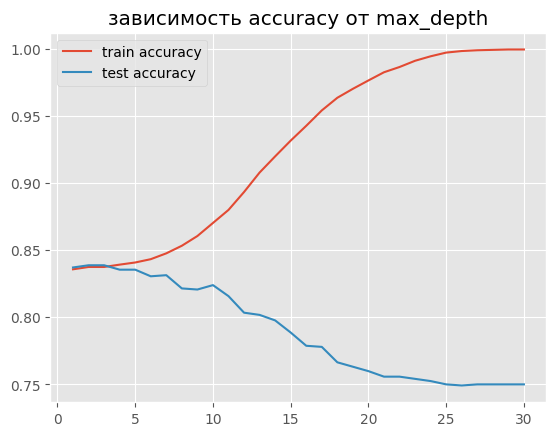

In [83]:
plt.plot(range(1, 31), train_scores, label='train accuracy')
plt.plot(range(1, 31), test_scores, label='test accuracy')
plt.legend()
plt.title('зависимость accuracy от max_depth')
plt.show()

Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн.
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации?

Из графика видно, что при глубине дерева > ~4, качество на валидации начинает падать и с последующим увеличением глубины становится только хуже. При этом качество на трейне растет и стремится к 1, что говорит о переобучении модели.

## Зависимость точности от min_samples_split

In [144]:
train_scores = []
test_scores = []

for samples in range(1, 15):
    my_clf = MyDecisionTreeClassifier(min_samples_split=samples, max_depth=5, criterion='gini')
    my_clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_true=y_train, y_pred=my_clf.predict(X_train)))
    test_scores.append(accuracy_score(y_true=y_test, y_pred=my_clf.predict(X_test)))

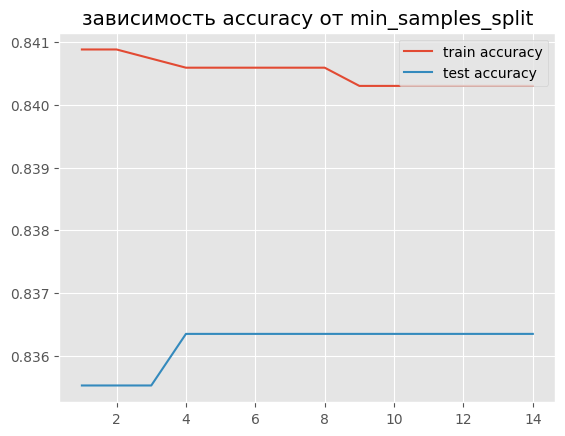

In [145]:
plt.plot(range(1, 15), train_scores, label='train accuracy')
plt.plot(range(1, 15), test_scores, label='test accuracy')
plt.legend()
plt.title('зависимость accuracy от min_samples_split')
plt.show()

При увеличении числа сэмплов для разбиения на трейне качество чуть падает, при этом на валидации заметно, что обобщающая способность улучшилась(но в обоих случаях изменения не критичные).

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве.

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший.
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева.

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [125]:
my_clf = MyDecisionTreeClassifier()
my_clf.fit(X, y)

In [142]:
importances_dict = my_clf.feature_importances_
top10features = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)[:10]
feature_names = df.drop(columns='match').columns
for feature_id, q in top10features:
  print(f'{feature_names[feature_id]}: {q}')

pid: 0.6293078949312159
race: 0.40816326530612246
int_corr: 0.17347125739902527
imprace: 0.09703884133632806
exphappy: 0.06583183966107226
iid: 0.06162586980331719
samerace: 0.009336419753086356
age: 0.007253615591136409
amb3_1: 0.005367648408492409
intel2_1: 0.0032264652219005097


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

Домашка разложила все, что связано с построением деревьев по полочкам, все супер понятно.

### Ваш ответ здесь

Домашка заставила попотеть - особенно раздел с оптимизацией, который мне так и не поддался(хотя я ради него просрочить дедлайн решила). Наверно, хотелось бы узнать, как можно провести оптимизациию и как это реализовано в sklearn.